In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster import hierarchy
from sklearn.preprocessing import MinMaxScaler
import os, glob, inspect, sys
import re
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
import epri_mc_lib_2 as mc
from importlib import reload
reload(mc)


<module 'epri_mc_lib_2' from '/home/nick/Bureau/Programming/S2DS/Oct20_EPRI/Task2/NB/epri_mc_lib_2.py'>

### Import data and merge replicates

In [169]:
merged = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), '../Data/Merged_data/MERGE_FT_TEP_UT_on_ID.csv'),
                    index_col=0)
merged.index = merged.index.str.rstrip('-12345')
mean_df = merged.groupby('ID').mean()
# Get rid of cold work
cw_regex = re.compile("[0-9]+$") 
mean_df['cold_work'] = [str(re.search(cw_regex,x).group()) for x in mean_df.index]
mean_df.index = mean_df.index.str.rstrip('02468')
mean_df.index = mean_df.index.str.rstrip('-')

## Select columns of interest

In [170]:
mean_df = mean_df[mc.regression_cols].dropna().drop('A286', axis=0)
log_kjic = np.log(mean_df.KJIC)
mean_df.drop(columns=['KJIC'], inplace=True)


## Scale data

In [173]:
scaled_df = mc.scale_general(mean_df, MinMaxScaler())[0]
scaled_kjic = mc.scale_general(pd.DataFrame(log_kjic), MinMaxScaler())[0]


### PCA

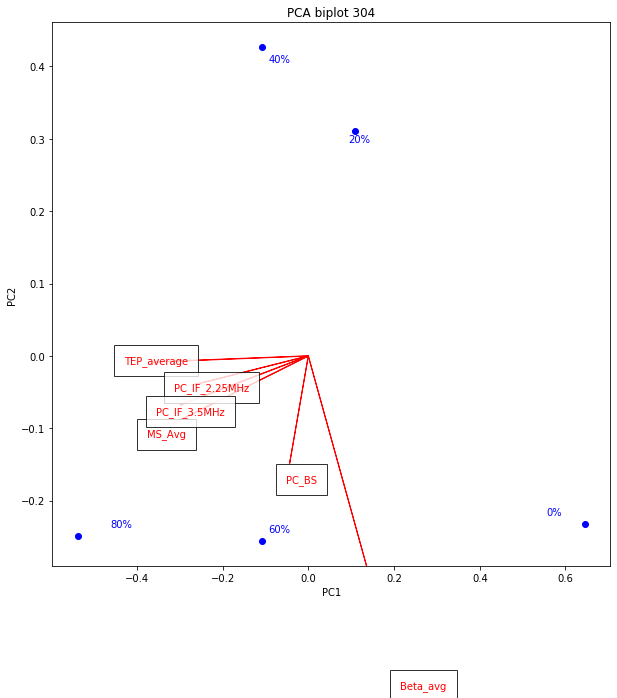

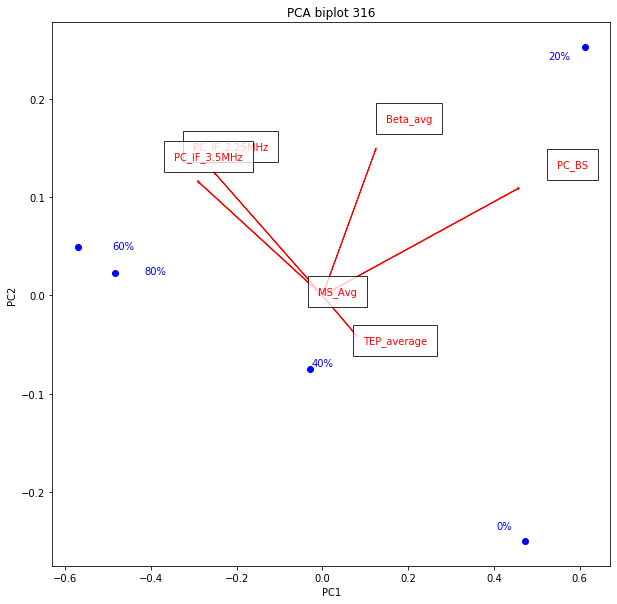

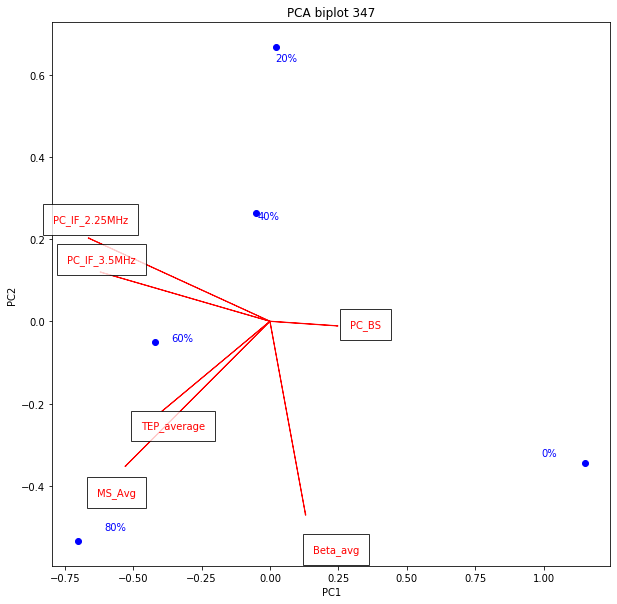

In [152]:
for ind in scaled_df.index.unique():
    subset_dr = scaled_df[scaled_df.index==ind].copy()
    subset_dr.index = subset_dr.cold_work
    subset_dr.drop(columns=['cold_work'],inplace=True)
    subset_dr.rename(index={0.00:'0%',0.25:'20%',0.50:'40%',0.75:'60%',1.00:'80%'},inplace=True)
    pca = PCA(n_components=4, svd_solver='full')
    pca.fit(subset_dr)
    color_dict = { '0%':'red', '20%':'blue', '40%':'green', '60%':'orange', '80%':'pink' }
    mc.biplot(pca, subset_dr, 0, 1, "PCA biplot "+ind)    

### Comparing to features

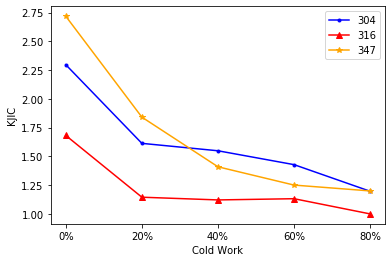

In [209]:
colors=['blue','red','orange']
markers=['.','^','*']
i=0

for ind in scaled_df.index.unique():
    subset_dr = scaled_df[scaled_df.index==ind].copy()
    subset_kjic = scaled_kjic[scaled_kjic.index==ind].copy()
    subset_dr.index = subset_dr.cold_work
    subset_dr.rename(index={0.00:'0%',0.25:'20%',0.50:'40%',0.75:'60%',1.00:'80%'},inplace=True)
    plt.plot(subset_dr.index,np.exp(subset_kjic), label=ind,c=colors[i],marker=markers[i])
    plt.xlabel('Cold Work')
    plt.ylabel('KJIC')
    plt.legend()
    i+=1

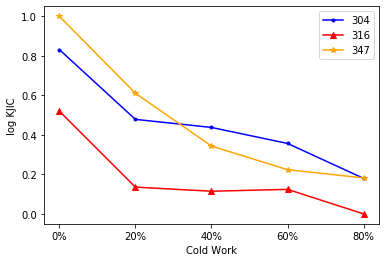

In [208]:
colors=['blue','red','orange']
markers=['.','^','*']
i=0

for ind in scaled_df.index.unique():
    subset_dr = scaled_df[scaled_df.index==ind].copy()
    subset_kjic = scaled_kjic[scaled_kjic.index==ind].copy()
    subset_dr.index = subset_dr.cold_work
    subset_dr.rename(index={0.00:'0%',0.25:'20%',0.50:'40%',0.75:'60%',1.00:'80%'},inplace=True)
    plt.plot(subset_dr.index,subset_kjic, label=ind,c=colors[i],marker=markers[i])
    plt.xlabel('Cold Work')
    plt.ylabel('log KJIC')
    plt.legend()
    i+=1

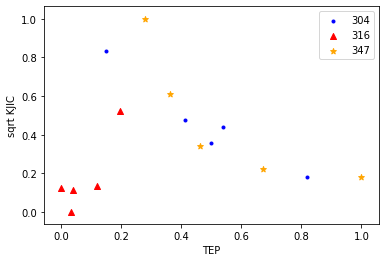

In [201]:
colors=['blue','red','orange']
markers=['.','^','*']
i=0
for ind in scaled_df.index.unique():
    subset_dr = scaled_df[scaled_df.index==ind].copy()
    subset_kjic = scaled_kjic[scaled_kjic.index==ind].copy()
    subset_dr.index = subset_dr.cold_work
    subset_dr.rename(index={0.00:'0%',0.25:'20%',0.50:'40%',0.75:'60%',1.00:'80%'},inplace=True)
    plt.scatter(subset_dr.TEP_average,subset_kjic, label=ind,c=colors[i],marker=markers[i])
    plt.xlabel('TEP')
    plt.ylabel('sqrt KJIC')
    plt.legend()
    i+=1

### "Regression" models

At this point a regression is pointless but it would be a linear regression so instead I'll just plot it and you can eyeball it to see what a fit line would behave like. Well 304 and 316 look linear but then again the PC1 is different between the two so does that really mean anything?

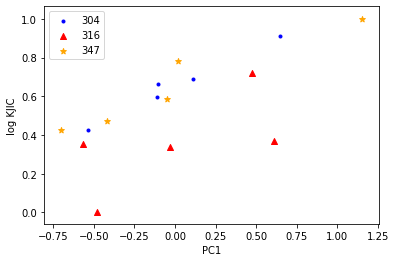

In [207]:
colors=['blue','red','orange']
markers=['.','^','*']
i=0
for ind in scaled_df.index.unique():
    subset_dr = scaled_df[scaled_df.index==ind].copy()
    subset_kjic = scaled_kjic[scaled_kjic.index==ind].copy()
    true_Y = np.sqrt(subset_kjic)
    subset_dr.drop(columns=['cold_work'],inplace=True)
    pca = PCA(n_components=1, svd_solver='full')
    xs = pca.fit_transform(subset_dr)
    plt.scatter(xs, true_Y, label=ind,c=colors[i],marker=markers[i])
    plt.xlabel('PC1')
    plt.ylabel('log KJIC')
    plt.legend()
    i+=1